## Faz o clustering (agrupamento) das reclamações conforme as categorias escolhidas

In [1]:
# importa bibliotecas
import pandas as pd
import os

# define a utilização de um thread somente na otimização do processamento
os.environ["OMP_NUM_THREADS"] = "1"

In [2]:
# carrega os dados do arquivo csv transformado
DADOS = 'arquivos_tratados/reclamações.csv'
df = pd.read_csv(DADOS)
df.head(3)

,rco,rn,rne,rs,rse,sf,sm,so,ate20,21a30,31a40,41a50,51a60,61a70,70+
0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


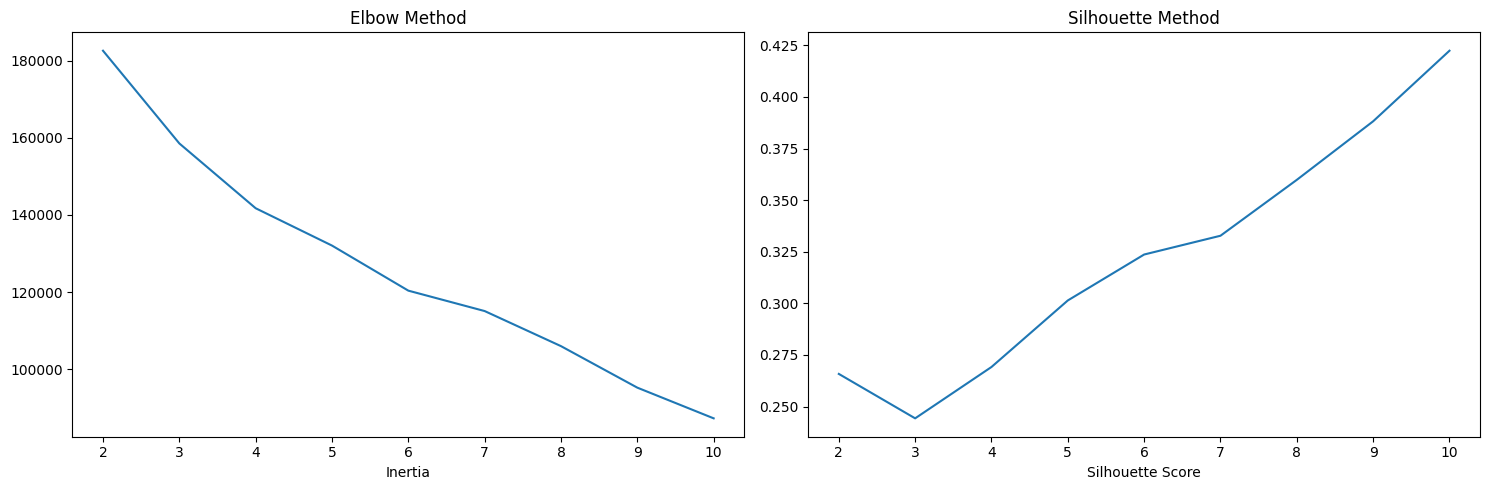

In [3]:
# gera os gráficos para definir a quantidade de clusters a serem gerados usando os métodos
# do COTOVELO e da SILHUETA - aqui definido que o melhor cluster terá tamanho de 5
from funcoes_auxiliares import graficos_elbow_silhouette

graficos_elbow_silhouette(df)

In [4]:
# treina e gera os clusters
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans.fit(df)
kmeans.labels_

array([0, 2, 1, ..., 0, 1, 0])

In [5]:
# salva o modelo dos clusters em arquivo .pkl
import joblib
joblib.dump(kmeans, "modelos/kmeans.pkl")

['modelos/kmeans.pkl']

In [6]:
# cria a coluna de cluster no dataframe de origem que forneceu os dados para geração
df_clustered = df.copy()
df_clustered["cluster"] = kmeans.labels_

df_clustered.head()

,rco,rn,rne,rs,rse,sf,sm,so,ate20,21a30,31a40,41a50,51a60,61a70,70+,cluster
0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2


In [7]:
# salva o arquivo clusterizado para não precisar gerar de novo
df_clustered.to_csv("arquivos_tratados/df_clustered.csv", index=False)

In [8]:
# le o arquivo clusterizado para dar sequência na análise daqui para frente
df_clustered = pd.read_csv('arquivos_tratados/df_clustered.csv')
df_clustered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126055 entries, 0 to 126054
Data columns (total 16 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   rco      126055 non-null  float64
 1   rn       126055 non-null  float64
 2   rne      126055 non-null  float64
 3   rs       126055 non-null  float64
 4   rse      126055 non-null  float64
 5   sf       126055 non-null  float64
 6   sm       126055 non-null  float64
 7   so       126055 non-null  float64
 8   ate20    126055 non-null  float64
 9   21a30    126055 non-null  float64
 10  31a40    126055 non-null  float64
 11  41a50    126055 non-null  float64
 12  51a60    126055 non-null  float64
 13  61a70    126055 non-null  float64
 14  70+      126055 non-null  float64
 15  cluster  126055 non-null  int64  
dtypes: float64(15), int64(1)
memory usage: 15.4 MB


In [9]:
# muda o nome das colunas para serem usadas pelo sql
df_clustered.columns = ['rco', 'rn', 'rne', 'rs', 'rse', 'sf', 'sm', 'so', 'x', 'a', 'b', 'c', 'd', 'e', 'f', 'cluster']

In [10]:
# agrupa as quantidades das categorias por cluster
from pandasql import sqldf

df_catclus = sqldf(" select cluster, sum(rco) as rco, sum(rn) as rn,   sum(rne) as rne, " \
                        "            sum(rs) as rs,   sum(rse) as rse, sum(sf) as sf, " \
                        "            sum(sm) as sm,   sum(so) as so,   sum(x) as x, " \
                        "            sum(a) as a, sum(b) as b, sum(c) as c, " \
                        "            sum(d) as d, sum(e) as e, sum(f) as f " \
                        " from df_clustered " \
                        " group by cluster" \
                        " order by cluster"
      )

In [11]:
# volta o nome original das colunas
df_catclus.columns = ['cluster', 'rco', 'rn', 'rne', 'rs', 'rse', 'sf', 'sm', 'so', 'ate20', '21a30', '31a40', '41a50', '51a60', '61a70', '70+']

   cluster     rco      rn      rne       rs      rse       sf       sm    so  \
0        0     0.0     0.0      0.0      0.0  25125.0  25106.0      0.0  19.0   
1        1     0.0     0.0      0.0      0.0  35677.0      0.0  35640.0  37.0   
2        2  8617.0  3441.0  13820.0      0.0      0.0      0.0  25872.0   6.0   
3        3     0.0     0.0      0.0  22533.0      0.0   9829.0  12691.0  13.0   
4        4  5611.0  2406.0   8825.0      0.0      0.0  16812.0      0.0  30.0   

   ate20   21a30    31a40   41a50   51a60   61a70    70+  
0  198.0  6059.0   8437.0  5353.0  2750.0  1753.0  575.0  
1  459.0  7913.0  13420.0  8215.0  3313.0  1773.0  584.0  
2  409.0  6666.0   9701.0  5211.0  2054.0  1274.0  563.0  
3  270.0  5205.0   7632.0  4635.0  2491.0  1658.0  642.0  
4  173.0  4126.0   5152.0  3558.0  1862.0  1368.0  603.0  


<Axes: title={'center': 'Categorias Agrupadas por Cluster'}, xlabel='cluster'>

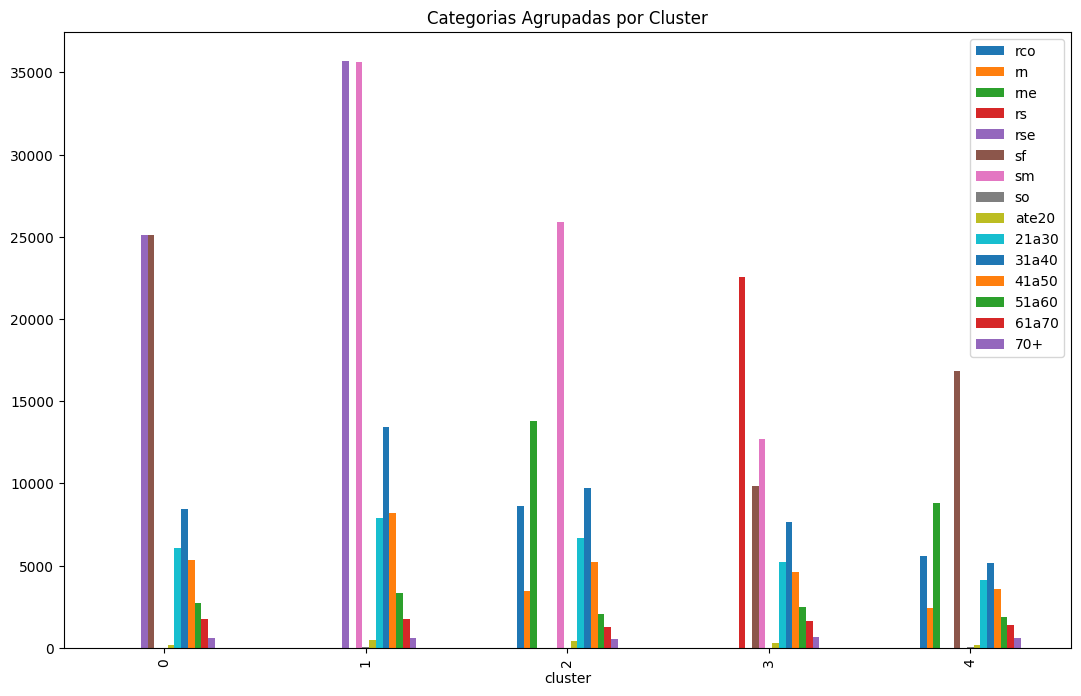

In [12]:
# verifica a quantidade de ocorrências de cada categoria para caracterizar o cluster
print(df_catclus) 

df_catclus.plot(x='cluster', 
        kind='bar', 
        stacked=False, 
        title='Categorias Agrupadas por Cluster',
        figsize=(13,8))

##### Grupos (clustering) de consumidores reclamantes (categoriza os clusters criados)

- Cluster 0 - Sudeste - mulher - idade 21a50
- Cluster 1 - Sudeste - homem - idade 21a50
- Cluster 2 - C.Oeste-Norte-Nordeste - homem - idade 21a50
- Cluster 3 - Sul - mulher-homem - idade 21a50
- Cluster 4 - C.Oeste-Norte-Nordeste - mulher - idade 21a50

transformando os pontos acima em uma tabela:

Região | Sexo | Idade | Número Cluster
--- | --- | --- | ---
Sudeste | mulher | 21a50 | 0
Sudeste | homem | 21a50 | 1
C.Oeste-Norte-Nordeste | homem | 21a50 | 2
Sul | mulher-homem | 21a50 | 3
C.Oeste-Norte-Nordeste | mulher | 21a50 | 4